In [1]:
# import sys

from gp_sinkhorn.SDE_solver import solve_sde_RK
from gp_sinkhorn.MLE_drift import *
from gp_sinkhorn.utils import plot_trajectories_2


import copy
import torch
import math
import numpy as np

from celluloid import Camera
from IPython.display import HTML
import matplotlib.pyplot as plt

#  Dataset that can break  Our algorithm due to means being too far

In [2]:
num_samples = 50
X_0 = torch.distributions.normal.Normal(loc=0, scale=0.5).sample((num_samples, 1)) #.reshape(num_samples, dim,-1)

X_1_a = torch.distributions.normal.Normal(loc=-7, scale=0.6**2).sample((num_samples//2, 1)) 
X_1_b = torch.distributions.normal.Normal(loc=-12, scale=0.6**2).sample((num_samples//2, 1))
X_1 = torch.cat((X_1_a,X_1_b))

In [3]:
prior_X_0=torch.cat((X_1,X_0))
prior_X_0.shape
# prior_X_0 = None

torch.Size([100, 1])

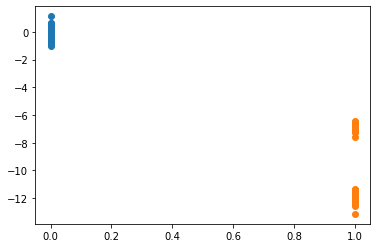

In [4]:
plt.scatter([0]*X_0.shape[0],X_0)
plt.scatter([1]*X_0.shape[0],X_1)

# Set $\sigma$ to 1 or 0.5 here to see how the method falls appart.


## UPDATE ! We implemented annealing which has some theoretical basis for the SBP it solves this issue mostly

This is an interesting example that illustrates just how local structure and more time  is enough to go quite far.

By this I mean (if you look at the plots in time as a video (might be worth animating):


1. First you can see that only one mode is abel to be reached and abel to reach the center going backwards at this current level of Brownian motion
2. Once the nearest mode is reached then you see IPFP starts to reach out to the very far away mode pigybacking on the reached mode
3. This teahes us 2 things about the algorithm. One that for things that are very far in mean there needs to be some sort of spatial structure for me to get there. Two the prior matters a lot, imagine if I had a drift which somehow rescaled things to not make them look far or that it transported me to the general area where the two modes are . Our algorithm is very good at matching local structure very well spliting reshaping etc , but it really struggles to make big spatial jumps that are bigger than the diffusion.
4. Back to the previous point if I had a prior which was just a linear interpolation drift that takes me to the mean of the orange dataset this would solve this issue to some point, Austen mentioned linear interpolation drift augmented Brownian priors in cases where you dont have much prior knowledge as a start at some point. 
    - More concretely I mean add a linear drift to the prior $b(X,t) = mt + c$
    - where m and c are fitted  from the means of both datasets
    - a better approach could be something piecewise linear based on range (could do some clustering to initilalise etc)
5. Annealing the temperature turns out ot be the simplest solution
    
In short I believe in the cases where the algo strugles is becaus we dont have a particularly good prior, this algorithm is good at solving the hard / interesting part (spliting modes, matching kurtosis, skewness and compelx curvatures) but jumping over huge distances in space (which is boring) is not its forte. 

NOTE: The linear interpolation modification to the prior proposed in 4, has an obvious failure case imagine the two mixtures being symmetrically centered around 0 their mean would be 0 , thus some clustering styled solution would be required. Could also do quantiles and uniformly send things to different quantiles (this could be nice). Would love to hear your thoughts on this problem and the proposed solutions.

Hoping for the embryo data that more timesteps + more IPFP iterations + sigma=1.5 will solve it but if not we need more thought. 

Could try rescaling the data but thats very analogous to scaling sigma up it can make the trajectories seem too noisy.


NOTE 2: Notice that our method only requires one or two samples to hit the target and then it very quickly and automatically starts covering the space which is nice. 

In [5]:
sigma=2.5 # Works at 1.5 breaks at 0.5, what to do ?
sigma_target = 1

mod = 5
iteration = 100

increments = int(iteration / mod)
#  sigma_target =  sigma * decay_sigma**iteration 
decay_sigma = (sigma_target/sigma)**(1.0/increments)
print(decay_sigma)
sigma_test = sigma
for i in range(increments):
    sigma_test *= decay_sigma
    print(sigma_test)

0.955219103952324
2.38804775988081
2.281108841388702
2.17895874348904
2.0813830185046824
1.9881768219176261
1.899144482330934
1.8140990906881551
1.7328621078878652
1.655262989969582
1.5811388300841889
1.5103340164972447
1.4426999059072128
1.3780945113927898
1.3163822043342364
1.2574334296829344
1.2011244339814302
1.1473370055629841
1.0959582263852163
1.0468802349768647
0.9999999999999991


In [6]:
N=50
import os
os.environ["DIR_LOG"] = ""
result = MLE_IPFP(
    X_0,X_1,prior_X_0=prior_X_0, sparse=False, num_data_points=50, num_time_points=25,sigma=sigma, N=N,
    iteration =iteration, plot=False, decay_sigma=decay_sigma,refinement_iterations=5, div=mod
)

100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [03:22<00:00,  1.93s/it]


(<Figure size 1080x720 with 1 Axes>, <AxesSubplot:ylabel='$x(t)$'>)

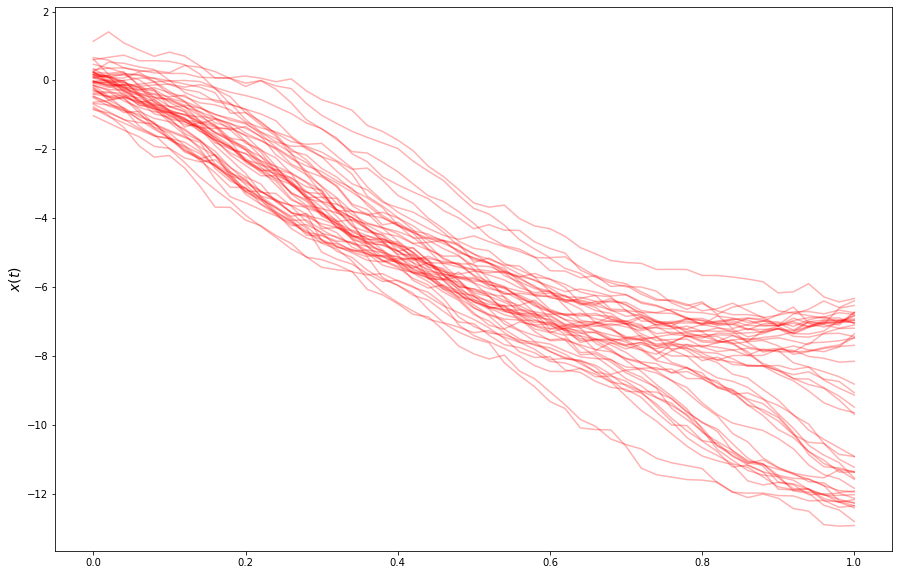

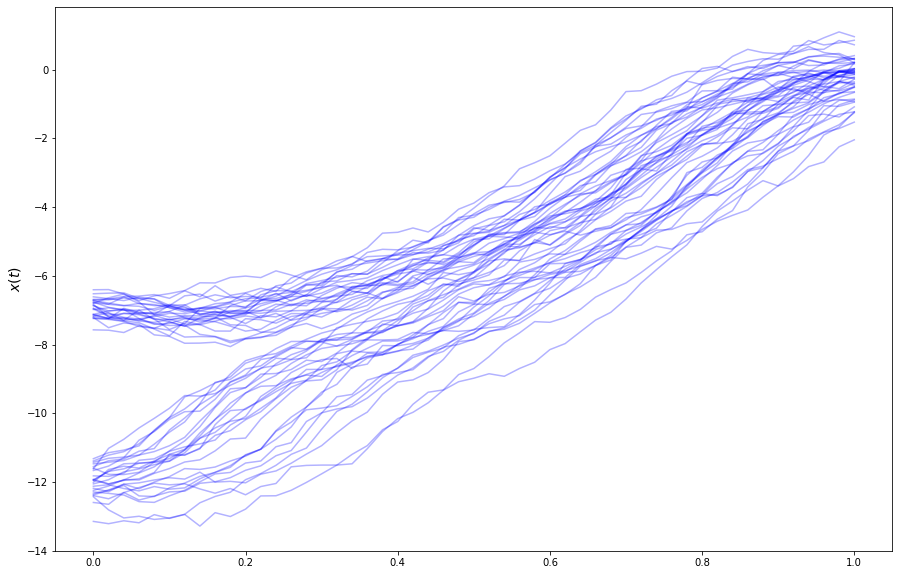

In [7]:
T,M,T2,M2 = result[-1]
plot_trajectories_2(M,T, color="red")
plot_trajectories_2(M2,  T2)

In [14]:
N

50